# **Importing Required Libraries**

In [ ]:
# TensorFlow and Keras for model building
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

# Other utilities
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# **Defininig of Constants**

In [ ]:
IMAGE_SIZE = 110 #The size to which images will be resized.
BATCH_SIZE = 128 #Number of images per batch during training.
CLASSES = 2 #The number of output classes (in this case, 2: "Orange" and "Not Orange").

# **Mounting of Google Drive and Loading of Datasets**

In [ ]:
drive.mount('/content/drive')

dataset = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/Orange_DS/Two Classes", #Dataset file path
shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE), #Since I put 110 for image size on the constants "IMAGE_SIZE, IMAGE_SIZE" will be 110 x 110
batch_size=BATCH_SIZE
)

#Calls and Displays classes from dataset
class_names = dataset.class_names
class_names

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1821 files belonging to 2 classes.


['Not Orange', 'Orange']

# **Plotting**

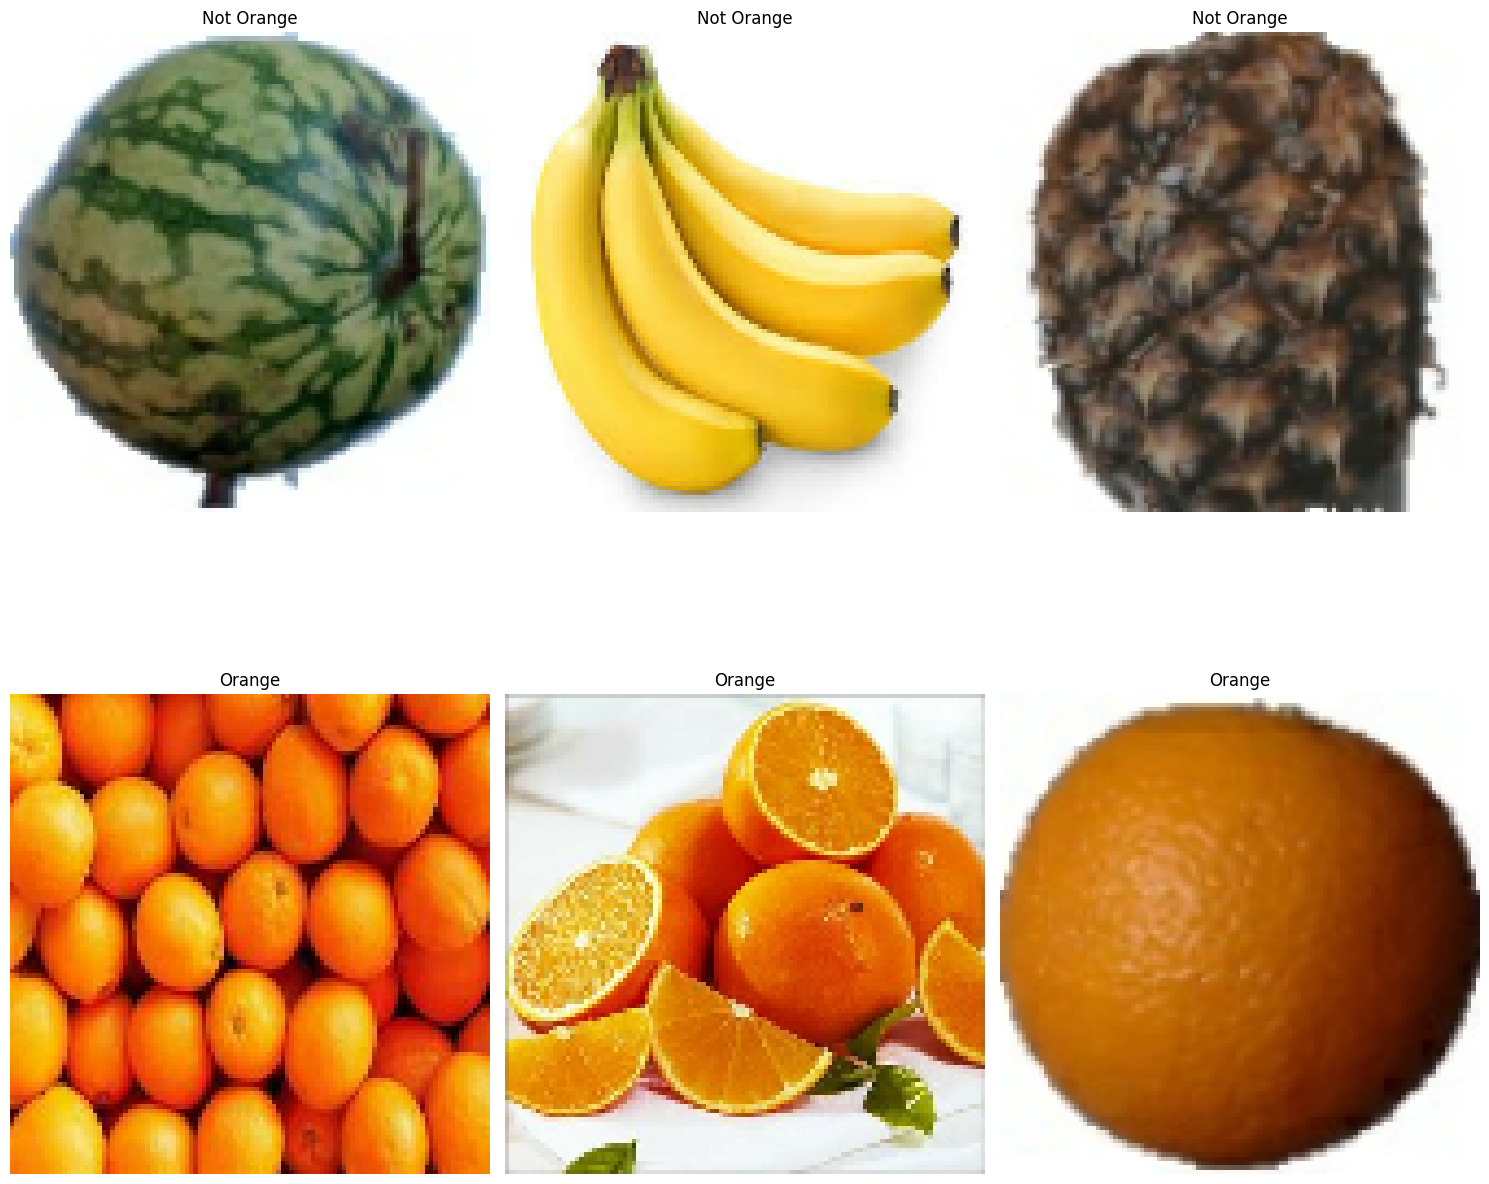

In [ ]:
import matplotlib.pyplot as plt


class_names_of_interest = ['Not Orange', 'Orange'] #I have 2 classes which are Not Orange and Orange (can add depending on classes)

# Ensure these class names match with dataset.class_names
class_indices = [class_names.index(name) for name in class_names_of_interest]  # Get class indices

# Initialize a dictionary to store a few images per class
healthy_images = {name: [] for name in class_names_of_interest}

# Collect 3 sample images per selected class (Can change number if you want more/less images)
for images, labels in dataset:
    for i in range(len(labels)):
        label = labels[i].numpy()

        # Critical: Ensure your label mapping logic works (Some datasets may return one-hot encoded labels)
        if label in class_indices and len(healthy_images[class_names[label]]) < 3:
            healthy_images[class_names[label]].append((images[i], labels[i]))

        # Varies: Stop when 3 samples for each class are collected (Change 3 if you want more/less)
        if all(len(healthy_images[name]) == 3 for name in class_names_of_interest):
            break
    if all(len(healthy_images[name]) == 3 for name in class_names_of_interest):
        break

# Plot the images
plt.figure(figsize=(15, 15))  # 🔄 Varies: Adjust figure size based on number of classes or samples per class
for i, name in enumerate(class_names_of_interest):
    for j, (image, label) in enumerate(healthy_images[name]):
        ax = plt.subplot(len(class_names_of_interest), 3, i * 3 + j + 1)  # "3" is samples per class
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(name)
        plt.axis("off")

plt.tight_layout()
plt.show()

# **Image Augmentation Functions**

In [ ]:
# Several functions are defined to randomly modify images to improve model generalization.
#These includes the following:
def Crop(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image
    return image

def Rotate(image):
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image

    return image

def Contrast(image):
    image = keras.layers.RandomContrast(0.2)(image)  # Randomly adjust contrast

    return image

def Flip(image):
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image

    return image

def Brightness(image):
    image = keras.layers.RandomBrightness([0.1, 0.4])(image)  # Randomly adjust brightness

    return image

def Zoom(image):
    image = keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))(image)
    return image


# Function for augmenting images using preprocessing layers
def augment(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image
    image = keras.layers.RandomContrast(0.1)(image)  # Randomly adjust contrast
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image
    image = keras.layers.RandomBrightness([0.1, 0.4])(image)  # Randomly adjust brightness
    image = keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))(image)  # Randomly zoom image

    return image

# Load and augment the training set. Data Splitting is 70% training, 20% validation, and 10% testing

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.20, test_split=0.10, shuffle=True, shuffle_size=1000, augment_data=True):

    # Get length of dataset
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset before splitting

    # Compute percentage accordingly from dataset size
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Split the dataset into training, validation, and test sets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    # Fix: Apply augmentations correctly by using a lambda function to only pass the image to the augmentation functions
    if augment_data:
        # Create augmentation layer instances outside the map function
        crop_layer = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)
        rotate_layer = keras.layers.RandomRotation(0.2)
        contrast_layer = keras.layers.RandomContrast(0.2)
        flip_layer = keras.layers.RandomFlip("horizontal_and_vertical")
        brightness_layer = keras.layers.RandomBrightness([0.1, 0.2])
        zoom_layer = keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))

        train_ds = train_ds.map(lambda image, label: (crop_layer(image), label)) # Using crop_layer instead of Crop function
        train_ds = train_ds.map(lambda image, label: (rotate_layer(image), label)) # Using rotate_layer instead of Rotate function
        train_ds = train_ds.map(lambda image, label: (contrast_layer(image), label)) # Using contrast_layer instead of Contrast function
        train_ds = train_ds.map(lambda image, label: (flip_layer(image), label)) # Using flip_layer instead of Flip function
        train_ds = train_ds.map(lambda image, label: (brightness_layer(image), label)) # Using brightness_layer instead of Brightness function
        train_ds = train_ds.map(lambda image, label: (zoom_layer(image), label)) # Using zoom_layer instead of Zoom function

    return train_ds, val_ds, test_ds

# Assuming you already loaded your dataset into `dataset`
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# **Caching of Datasets for faster training**

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Building the CNN Model (EfficientNetB0)**
fine-tunes it with regularized dense layers to classify images into 2 categories. The use of batch normalization, dropout, and L2 regularization improves generalization and prevents overfitting.

In [ ]:
efficientnet_model = keras.Sequential() #This initializes an empty Sequential model, meaning layers will be stacked in order

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg') #include_top=False: Removes the original classification head, allowing customization. input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3): Defines the input image size (with 3 channels for RGB). pooling='avg': Uses Global Average Pooling, reducing spatial dimensions while keeping feature richness

# Predection Layer
predictions = Dense(2, activation='softmax') #Creates a fully connected (Dense) layer with 2 output nodes (for binary classification). activation='softmax': Converts output into class probabilities.

for layer in base_model.layers:
    layer.trainable = False # Freeze pre-trained layers



efficientnet_model.add(base_model) # Layer for your actual model
efficientnet_model.add(layers.Flatten()) #Converts the multi-dimensional feature map into a 1D vector for the next dense layers.

# Regularization and Dropout
efficientnet_model.add(layers.Dense(64, activation='relu', kernel_regularizer=L2(0.01)))
efficientnet_model.add(layers.BatchNormalization())
efficientnet_model.add(layers.Dropout(0.5))

efficientnet_model.add(layers.Dense(32, activation='relu'))
efficientnet_model.add(layers.BatchNormalization())
efficientnet_model.add(layers.Dropout(0.2))

efficientnet_model.add(predictions) # This layer is responsible for your predictions

efficientnet_model.summary() # Summarizes and shows the entire layers of your model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,134,085 (15.77 MB)

 Trainable params: 84,322 (329.38 KB)

 Non-trainable params: 4,049,763 (15.45 MB)

# **Compiling and Training the Model**

In [ ]:
# Compile the model with an Adam optimizer and categorical crossentropy loss
efficientnet_model.compile(optimizer=Adam(learning_rate=0.001, decay=0.01), #Why Adam optimizer? it is the default go-to optimizer for deep learning task, especially CNN
              loss='sparse_categorical_crossentropy', #Sparse categorical crossentropy loss is applied (since labels are integers).
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# **Training of the Model EfficientNetB0**

In [ ]:
# Training of the model on the dataset
history = efficientnet_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.7013 - loss: 1.8283 - val_accuracy: 0.6772 - val_loss: 1.6670
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9559 - loss: 1.2926 - val_accuracy: 0.7860 - val_loss: 1.4565
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9851 - loss: 1.1314 - val_accuracy: 0.8842 - val_loss: 1.2506
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9877 - loss: 1.0165 - val_accuracy: 0.9333 - val_loss: 1.0587
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9961 - loss: 0.8955 - val_accuracy: 0.9825 - val_loss: 0.8870
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9955 - loss: 0.7912 - val_accuracy: 0.9895 - val_loss: 0.7597
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9978 - loss: 0.6893 - val_accuracy: 0.9965 - val_loss: 0.6587
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9976 - loss: 0.6045 - val_accuracy: 0.9965 - val_loss:

# **Evaluating Performance**
The best and final accuracy/loss values are displayed.

In [ ]:
#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history.history['accuracy']))
print("Highest Validation Accuracy: ", max(history.history['val_accuracy']))
print("Lowest Loss: ", min(history.history['loss']))
print("Lowest Validation Loss: ", min(history.history['val_loss']))
print("Final Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])

Highest Accuracy:  1.0
Highest Validation Accuracy:  1.0
Lowest Loss:  0.1287306249141693
Lowest Validation Loss:  0.14038605988025665
Final Accuracy:  0.9976562261581421
Final Validation Accuracy:  0.9964912533760071
Final Loss:  0.1287306249141693
Final Validation Loss:  0.14038605988025665


# **Making Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


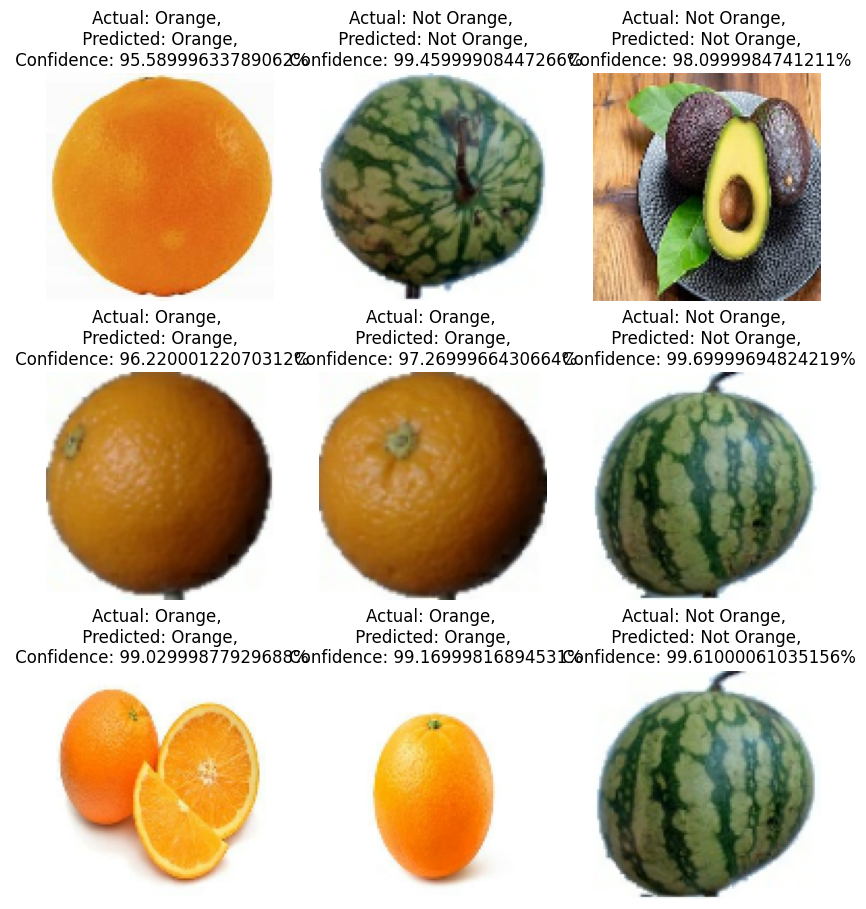

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Add batch dimension

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(10, 11))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(efficientnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
scores = efficientnet_model.evaluate(test_ds) # Fined Tune

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9948 - loss: 0.1449


# **Classification Report**

In [ ]:
# code to view f1 score and other metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = efficientnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
F1 Score: 0.9960929731362921
Precision: 0.9961226851851852
Recall: 0.99609375
Accuracy: 0.99609375
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       122
           1       0.99      1.00      1.00       134

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



# **Confusion Matrix**
A confusion matrix is plotted to visualize model performance.

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step


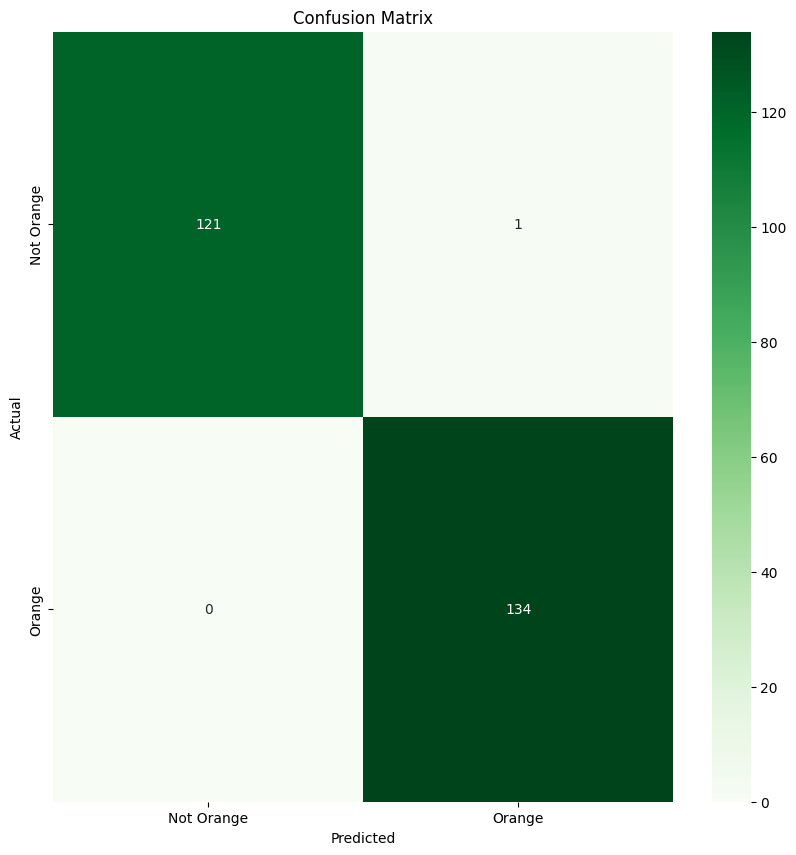

In [ ]:
#code block to show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []  # Initialize an empty list to store predictions
y_true = []  # Initialize an empty list to store true labels

# Iterate through the test dataset in batches
for images, labels in test_ds:
    # Get predictions for the current batch
    predictions = efficientnet_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Extend the prediction and true label lists
    y_pred.extend(predicted_labels)
    y_true.extend(labels.numpy())

# Convert the lists to NumPy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# **Training Graphs**
Accuracy and loss curves are plotted for both training and validation.

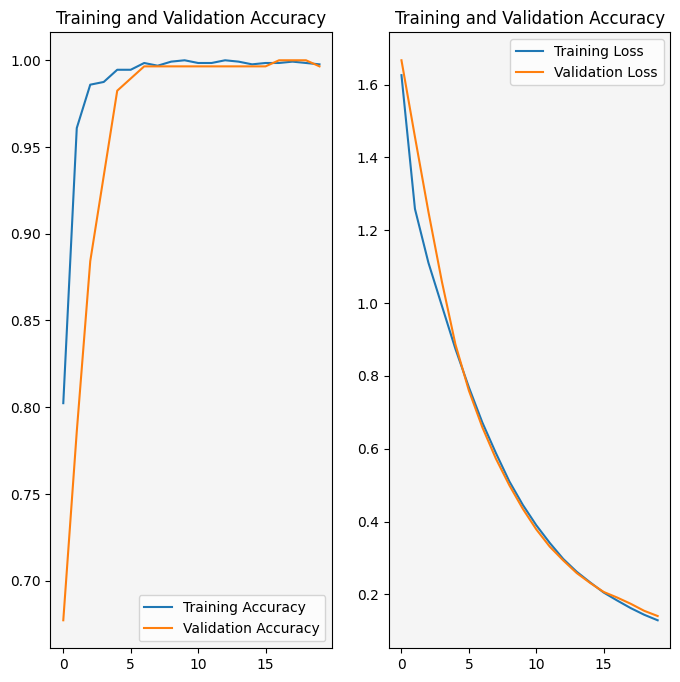

In [ ]:
completed_epochs = len(history.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

# **Saving the Model**
The trained model is saved in Google Drive, ensuring different versions are stored.

In [ ]:
# Define model save path inside Google Drive
save_dir = "/content/drive/MyDrive/model(EfficientNet)NFT"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Find the latest model version
model_version = max([int(i) for i in os.listdir(save_dir) if i.isdigit()] + [0]) + 1

# Save the model
efficientnet_model.save(f"{save_dir}/{model_version}.keras")  # Add .keras extension

print(f"Model saved at: {save_dir}/{model_version}.keras")  # Update print statement

Model saved at: /content/drive/MyDrive/model(EfficientNet)NFT/1.keras


# **Manual Testing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
from tensorflow import keras
from google.colab import files
from PIL import Image
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the trained model
model = keras.models.load_model('/content/drive/My Drive/model(EfficientNet)NFT/1.keras')

# Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

# Load and preprocess the image
IMAGE_SIZE = 110  # Ensure this matches training size
img = Image.open(image_path)
img = img.convert("RGB")  # Ensure it's in RGB mode

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Manual Testing")
plt.show()
img = img.resize((IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training
img = np.array(img)  # Convert to NumPy array
img = preprocess_input(img)  # EfficientNet preprocessing
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Get model prediction
prediction = model.predict(img)
print(f"Raw Prediction Output: {prediction}")

# Get predicted class index
predicted_class = np.argmax(prediction)
confidence_score = prediction[0][predicted_class]  # Confidence of predicted class

# Verify class ordering (Adjust if needed)
class_names = ['Not Orange', 'Orange']  # Ensure this matches training labels
predicted_label = class_names[predicted_class]

print(f"Predicted Label: {predicted_label} (Confidence: {confidence_score:.4f})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving orange-fruit.jpg to orange-fruit (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw Prediction Output: [[0.00819056 0.9918094 ]]
Predicted Label: Orange (Confidence: 0.9918)
